In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import glob

/Users/scott/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/scott/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/scott/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# Load data and format

In [2]:
path = r'data/'
allFiles = glob.glob("data/*.csv")
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=0, header=0)
    list_.append(df)
df = pd.concat(list_)
df.drop_duplicates(subset='PMCID', inplace=True)

In [3]:
# Only consider journals with a min number of articles
# vcs = df['Journal Title'].value_counts()
# journals_keep = list(vcs[vcs.values>2000].index)
journals_keep = ['Nat Commun', 'Front Psychol', 'PLoS Comput Biol', 'eLife', 'Front Hum Neurosci',
                 'PLoS Biol', 'Nature', 'Biol Psychiatry', 'PLoS One', 'Sci Rep']
df = df[df['Journal Title'].isin(journals_keep)]
df.drop_duplicates(subset='PMCID', inplace=True)

# Reset data and code upon request to not sharing
df.loc[df['data_upon_request']==1, 'data_shared'] = 0
df.loc[df['code_upon_request']==1, 'code_shared'] = 0

df = df[['Journal Title', 'Year', 'data_shared', 'code_shared', 'code_relevant', 'preregistration']]
df.reset_index(inplace=True, drop=True)
df.head()

,Journal Title,Year,data_shared,code_shared,code_relevant,preregistration
0,Nature,2017,1,0,1,0
1,Nature,2017,1,0,0,0
2,Nature,2017,1,0,0,0
3,PLoS One,2018,0,0,0,0
4,PLoS One,2018,0,0,1,0


# Data sharing

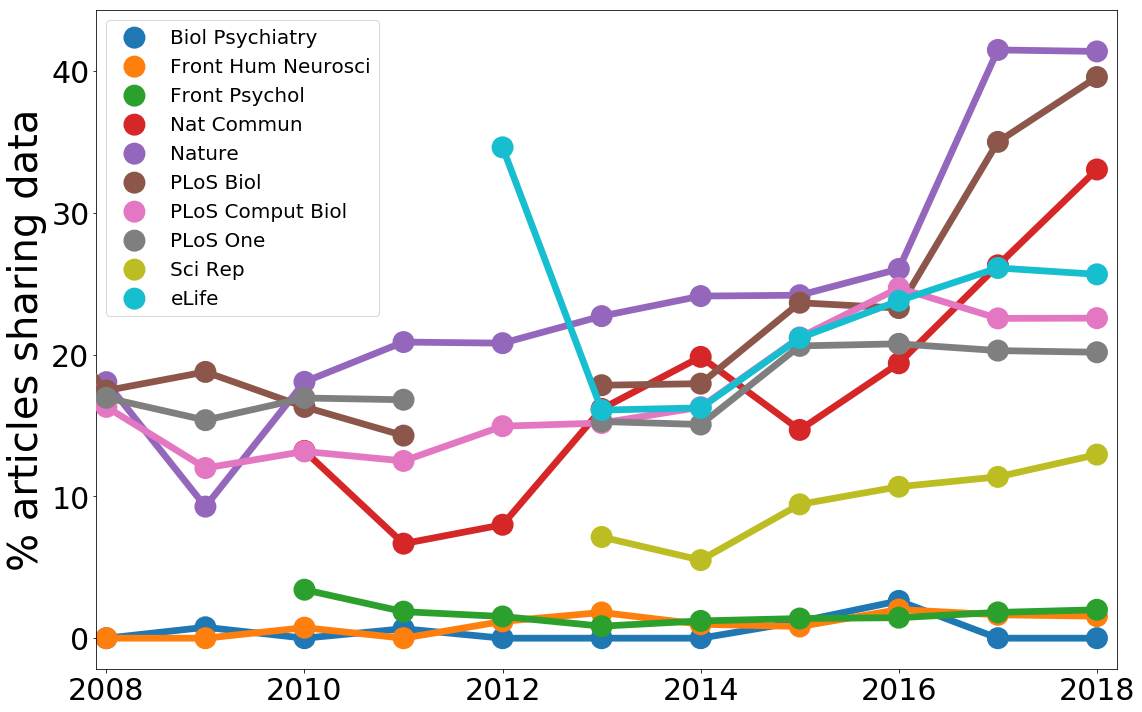

In [4]:
df_stats = df.groupby(['Journal Title', 'Year']).mean()['data_shared'].reset_index()
df_counts = df.groupby(['Journal Title', 'Year']).count()['data_shared'].reset_index().rename(columns={'data_shared':'count'})
df_stats = df_stats.merge(df_counts, on=['Journal Title', 'Year'])
df_stats = df_stats[df_stats['count']>10]

js_keep_plt = ['Nat Commun', 'Front Psychol', 'PLoS Comput Biol', 'eLife', 'Front Hum Neurosci',
                 'PLoS Biol', 'Nature', 'Biol Psychiatry', 'PLoS One', 'Sci Rep']
df_plt = df_stats[df_stats['Journal Title'].isin(js_keep_plt)]
df_plt['data_shared'] = df_plt['data_shared'] * 100

plt.figure(figsize=(16,10))
sns.pointplot(x='Year', y='data_shared', hue='Journal Title', data=df_plt, scale=2.5)
# plt.setp(plt.gca().collections, sizes=[200])
plt.xlabel('')
plt.ylabel('% articles sharing data', size=40)
plt.xticks(np.arange(0, 14, 2), np.arange(2006, 2020, 2), size=30)
plt.yticks(size=30)
plt.xlim((1.9,12.2))
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('data_sharing_by_year_10journals.png')

# Code sharing

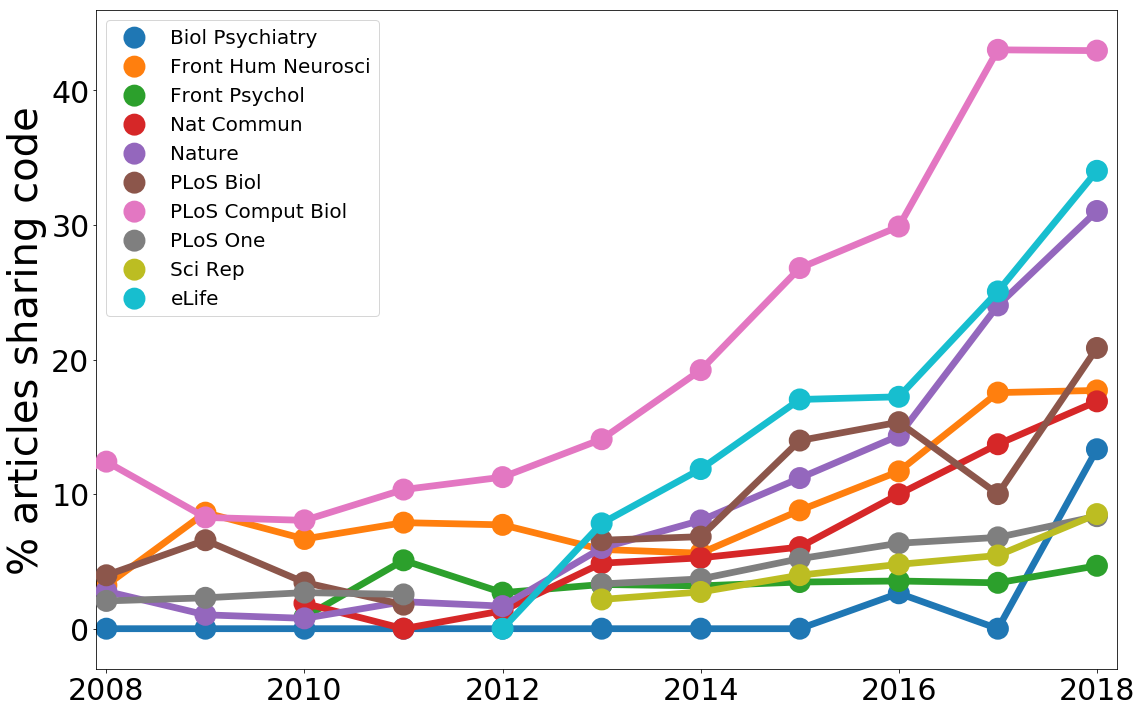

In [5]:
df_stats = df[df['code_relevant']==1]
df_stats = df.groupby(['Journal Title', 'Year']).mean()['code_shared'].reset_index()
df_stats = df_stats.merge(df_counts, on=['Journal Title', 'Year'])
df_stats = df_stats[df_stats['count']>10]

js_keep_plt = ['Nat Commun', 'Front Psychol', 'PLoS Comput Biol', 'eLife', 'Front Hum Neurosci',
                 'PLoS Biol', 'Nature', 'Biol Psychiatry', 'PLoS One', 'Sci Rep']
df_plt = df_stats[df_stats['Journal Title'].isin(js_keep_plt)]
df_plt['code_shared'] = df_plt['code_shared'] * 100

plt.figure(figsize=(16,10))
sns.pointplot(x='Year', y='code_shared', hue='Journal Title', data=df_plt, scale=2.5)
# plt.setp(plt.gca().collections, sizes=[200])
plt.xlabel('')
plt.ylabel('% articles sharing code', size=40)
plt.xticks(np.arange(0, 14, 2), np.arange(2006, 2020, 2), size=30)
plt.yticks(size=30)
plt.xlim((1.9,12.2))
plt.legend(fontsize=20)
plt.tight_layout()
plt.savefig('code_sharing_by_year_10journals.png')

# O Factors

In [6]:
years_keep = [2016, 2017]
dfo = df[df['Year'].isin(years_keep)]
dfo_data = dfo.groupby('Journal Title').mean()['data_shared'].reset_index()
dfo_code = dfo[dfo['code_relevant']==1].groupby('Journal Title').mean()['code_shared'].reset_index()
dfo_prereg = dfo.groupby('Journal Title').mean()['preregistration'].reset_index()
dfo = dfo_data.merge(dfo_code, on='Journal Title')
dfo = dfo.merge(dfo_prereg, on='Journal Title')
dfo['o'] = dfo[['data_shared', 'code_shared', 'preregistration']].sum(axis=1)

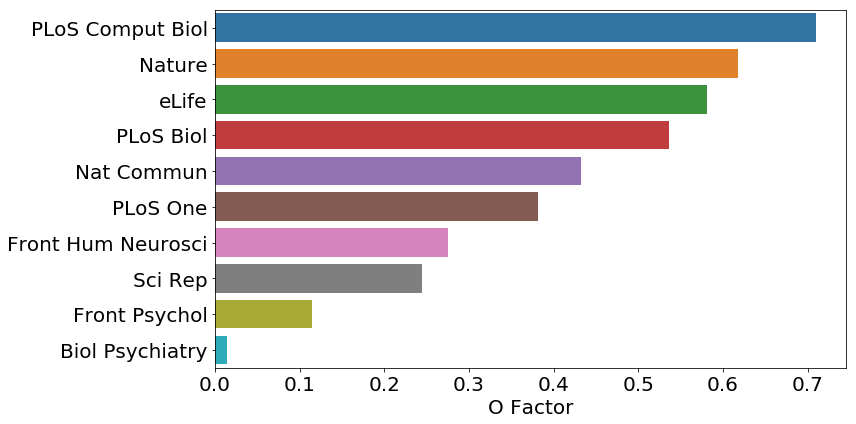

In [7]:
order = dfo.sort_values(by='o', ascending=False)['Journal Title']
plt.figure(figsize=(12,6))
sns.barplot(y='Journal Title', x='o', data=dfo, order=order)
plt.xlabel('O Factor', size=20)
plt.xticks(size=20)
plt.yticks(size=20)
plt.ylabel('')
plt.tight_layout()
plt.savefig('ofactor_rank.png')

# Correlate O factor to impact factor

In [8]:
df_if = pd.read_csv('ifs.csv')
dfo = dfo.merge(df_if, left_on='Journal Title', right_on='journal')

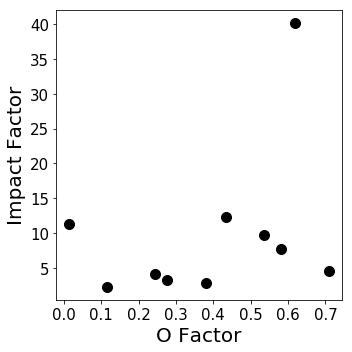

In [10]:
plt.figure(figsize=(5,5))
plt.plot(dfo['o'], dfo['if'], 'k.', ms=20)
plt.xlabel('O Factor', size=20)
plt.ylabel('Impact Factor', size=20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.tight_layout()
plt.savefig('ofactor_impact_corr.png')

In [11]:
from scipy import stats
stats.spearmanr(dfo['o'], dfo['if'])

SpearmanrResult(correlation=0.3939393939393939, pvalue=0.25999776683488757)